## Instructions

The head of analytics in your organization has specifically asked you to do the following:


1. Clean and tidy the datasets. 
2. Create a line plot to show the trend of `CO2` levels across the African regions.
3. Determine the relationship between time (`Year`) and `CO2` levels across the African regions.
4. Determine if there is a significant difference in the `CO2` levels among the African Regions.
5. Determine the most common (top 5) industries in each African region.
6. Determine the industry responsible for the most amount of CO2 (on average) in each African Region.
7. Predict the `CO2` levels (at each African region) in the year 2025.
8. Determine if `CO2` levels affect annual `temperature` in the selected African countries.

In [12]:
# Setup
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

plt.style.use('ggplot')
# The sheet names containing our datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11
# Let's skip the first 10 rows
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# we need only the African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')


# Read the temperatures datasets containing four African countries
# One from each African Region:
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')

## Instruction 1: Clean and tidy the datasets

### Tasks

- Rename `C_group_IM24_sh` to `Region`, `Country_code_A3` to `Code`, and `ipcc_code_2006_for_standard_report_name` to `Industry` in the corresponding African datasets.
- Drop `IPCC_annex`, `ipcc_code_2006_for_standard_report`, and `Substance` from the corresponding datasets.
- Melt `Y_1970` to `Y_2021` into a two columns `Year` and `CO2`. Drop rows where `CO2` is missing.
- Convert `Year` to `int` type.


In [14]:
#renaming
ipcc_2006_africa = ipcc_2006_africa.rename(columns={'C_group_IM24_sh': 'Region', 'Country_code_A3': 'Code',
                                                        'ipcc_code_2006_for_standard_report_name': 'Industry'})
totals_by_country_africa = totals_by_country_africa.rename(columns={'C_group_IM24_sh': 'Region','Country_code_A3': 'Code'})

# drop columns
ipcc_2006_africa = ipcc_2006_africa.drop(['IPCC_annex','ipcc_code_2006_for_standard_report','Substance'],axis=1)

totals_by_country_africa = totals_by_country_africa.drop(['IPCC_annex', 'Substance'], axis=1)

    # Melt and clean Year column

def melt_clean(df):
        value_vars = list(filter(lambda x: x.startswith('Y_'), df.columns))
        id_vars = list(set(df.columns).difference(value_vars))

        # melt
        long = df.melt(
            id_vars=id_vars,
            value_vars=value_vars,
            var_name='Year',
            value_name='CO2')

        # drop rows where co2 is missing
        long = long[~long.CO2.isnull()]

        # convert year to integer
        long.Year = long.Year.str.replace('Y_', '').astype(int)

        return long

ipcc_2006_africa = melt_clean(ipcc_2006_africa)
totals_by_country_africa = melt_clean(totals_by_country_africa)
 




## Instruction 2: Show the trend of `CO2` levels across the African regions

### Tasks

- Using `totals_by_country_africa`, create a line plot of `CO2` vs. `Year` in each `Region` to show the trend of CO2 levels by year.

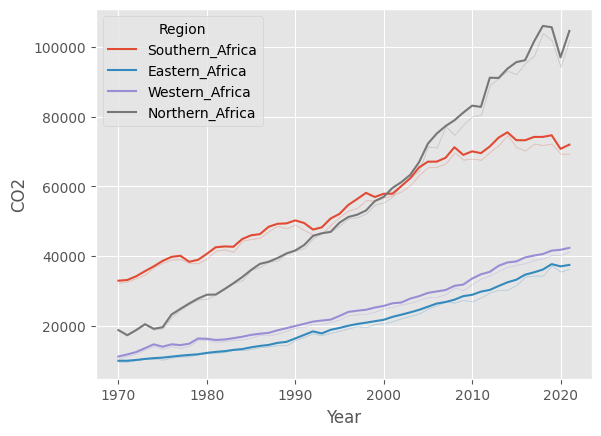

In [16]:
sns.lineplot(data = totals_by_country_africa,x='Year', y='CO2',hue='Region', ci = 0)

plt.show()



## Instruction 3: Determine the relationship between time (`Year`) and `CO2` levels across the African regions


### Tasks

- Using the `totals_by_country_africa` dataset, conduct a Spearman's correlation to determine the relationship between time (`Year`) and `CO2` within each African `Region`.
- Save the results in a variable called `relationship_btw_time_CO2`.


In [18]:
# Your code here
x = totals_by_country_africa.groupby("Region")["Year", "CO2"]
relationship_btw_time_CO2 =x.corr(method ='spearman')
relationship_btw_time_CO2.head()

Year       CO2
Region                                  
Eastern_Africa  Year  1.000000  0.181768
                CO2   0.181768  1.000000
Northern_Africa Year  1.000000  0.429875
                CO2   0.429875  1.000000
Southern_Africa Year  1.000000  0.260986

## Instruction 4: Determine if there is a significant difference in the CO2 levels among the African Regions

### Tasks

- Using `totals_by_country_africa`, conduct an ANOVA using `pingouin.anova()` on the `CO2` by `Region`. Save the results as `aov_results`.
- Conduct a posthoc test (with Bonferroni correction) using `pingouin.pairwise_tests()` to find the source of the significant difference. Save the results as `pw_ttest_result`.
- Is it true that the `CO2` levels of the `Southern_Africa` and `Northern_Africa` region do not differ significantly? The previous task should provide you with the answer.

In [20]:
#ANOVA
aov_results = pingouin.anova(data=totals_by_country_africa, dv='CO2', between='Region') 
    
pw_ttest_result = pingouin.pairwise_tests(data=totals_by_country_africa, dv='CO2', between='Region', padjust="bonf").round(3)

## Instruction 5: Determine the most common (top 5) industries in each African region.

### Tasks

- Group the `ipcc_2006_africa` data by `Region` and `Industry`.
- Count the occurrences of each `Industry` within each `Region` and name it `Count`.
- Sort the data within each region group by `Count` in descending order
- Get the top 5 industries for each region
- save it to variable `top_5_industries` for each region.

In [22]:
grouped = ipcc_2006_africa.groupby(['Region', 'Industry']).size().reset_index(name='Count')

grouped = grouped.sort_values(['Region', 'Count'], ascending=[True, False])

top_5_industries = grouped.groupby('Region').head(5).reset_index(drop=True)


## Instruction 6: Determine the industry responsible for the most amount of CO2 (on average) in each African Region

### Tasks

- Group the `ipcc_2006_africa` data by `Region` and `Industry`.
- Calculate the average `CO2` emissions for each group.
- Find the `Industry` with the maximum average `CO2` emissions in each region.

In [24]:
grouped = ipcc_2006_africa.groupby(['Region', 'Industry'])['CO2'].mean().reset_index() #grouping and getting mean

max_co2_industries = grouped.loc[grouped.groupby('Region')['CO2'].idxmax()].reset_index(drop=True)



print(max_co2_industries)

            Region                                       Industry           CO2
0   Eastern_Africa                  Residential and other sectors   7904.439282
1  Northern_Africa  Main Activity Electricity and Heat Production  13612.230148
2  Southern_Africa  Main Activity Electricity and Heat Production  11377.802504
3   Western_Africa                  Residential and other sectors   8702.936136


## Instruction 7: Predict the `CO2` levels (at each African region) in the year 2025

### Tasks

- Create an instance of `LinearRegression()` and save it as `reg`.
- Fit a linear model of `CO2` (in log base 10) by `Year` and `Region` using `reg.fit()`.
- Predict the values of `CO2` using the `reg.predict()` and the data provided. Save the result as `predicted_co2`. 
- Convert `predicted_co2` values from log base 10 to decimals and round to 2 d.p using `np.round()`.

In [28]:
reg = LinearRegression() #initialization of model 
newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)
#spliting Target and feature matrix 
target = np.log10(totals_by_country_africa['CO2'])
feats = pd.get_dummies(totals_by_country_africa[['Year', 'Region']])

#model
reg.fit(feats, target) 
p = reg.predict(newdata)
predicted_co2 = np.round(10**p, 2)
   


# data provided for you


## Instruction 8: Determine if CO2 levels affect annual temperature in the selected African countries

![relationship between co2 and temp](co2_temp.png)


### Tasks

- Select `Name`, `Year` and `CO2` of countries `countries`. Save the result as `selected_countries`.
- Convert `temperatures` dataset from wide to long format. Set the new column names to `Name` and `Temperature`. Save the result as `temp_long`.
- Perform an inner join between `selected_countries` and `temp_long` on `Name` and `Year`. Save the result as `joined`.
- Create a linear model of `Temperature` by `CO2` and `Name`. Save the result as `model_temp`. *The code has been added for you.*
- A one unit rise in log10 `CO2` leads to how many degrees rise in temperature? Run `model_temp.summary()` to find out!
- What is the adjusted R squared value of the model?

In [33]:
# Your code here
countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]

selected_countries =  totals_by_country_africa[['Name', 'Year','CO2']].query('Name in @countries')

#Melting Temperature
temp_long = temperatures.melt(
        id_vars=['Year'],
        value_vars=countries,
        var_name='Name',
        value_name='Temperature')

#joining Tables 
joined = pd.merge(selected_countries, temp_long, on=[
            'Name', 'Year'], how='inner')


model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3241.
Date:                Mon, 21 Aug 2023   Prob (F-statistic):          1.22e-182
Time:                        13:01:49   Log-Likelihood:                -54.347
No. Observations:                 208   AIC:                             118.7
Df Residuals:                     203   BIC:                             135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.4981      0.583     23.138      0.000      12.348      14.648
Name[T.Mozambique]     2.0759      0.090     23.021      0.000       1.898       2.254
Name[T.Nigeria]        2.8345      0.092     30.884      0.000       2.654       3.016
Name[T.Tunisia]       -1.6254      0.104    -15.673      0.000      -1.830      -1.421
np.log10(CO2)          1.9472      0.117     16.620      0.000       1.716       2.178
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.985
Skew:                          -0.291   Prob(JB):                        0.225
Kurtosis:                       3.073   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""